# Array classes: memory and performance profiling

In [1]:
import numpy as np
np.random.seed(42)
import sys
import cProfile
import humanize
import sh
sys.path.insert(0, '../..')
%reload_ext memory_profiler
%reload_ext autoreload
%autoreload 1
%aimport allel.model
%aimport allel.bcolz

In [2]:
def binarysize(n):
    return humanize.naturalsize(n, binary=True)

In [3]:
# setup an array of genotype calls
shape = n_variants, n_samples, ploidy = 50000, 1000, 2
data = np.zeros(shape, dtype='i1')
# simulate some mutations
n_alleles = n_variants * n_samples * ploidy
idx = np.random.randint(0, (n_alleles//2)-1, size=n_alleles//20)
data[:, :, 1].reshape((-1))[idx] = 1
data[:, :, 0].reshape((-1))[idx[:n_alleles//200]] = 1

## Total memory size

### Contiguous array (numpy)

In [4]:
g = allel.model.GenotypeArray(data, copy=False)
print(binarysize(g.nbytes))

95.4 MiB


### Compressed array (bcolz)

In [5]:
gc = allel.bcolz.GenotypeCArray(data)
print(binarysize(gc.cbytes), gc.chunklen)

16.0 MiB 262


### Compressed persistent array (bcolz)

In [6]:
import tempfile
rootdir = tempfile.mkdtemp()
rootdir

'/tmp/tmp_gzbyk3z'

In [7]:
gcp = allel.bcolz.GenotypeCArray(data, rootdir=rootdir, mode='w')
gcp.carr.flush()
print(binarysize(gc.cbytes), gc.chunklen)

16.0 MiB 262


### Arrays with mask 

In [8]:
mask = np.random.randint(0, 2, size=(n_variants, n_samples)).astype('b1')
gm = g.copy()
gm.mask = mask

In [9]:
gcm = allel.bcolz.GenotypeCArray(data)
gcm.mask = mask

### Sparse array (scipy)

In [10]:
m = g.to_sparse(format='csr')
m

<50000x2000 sparse matrix of type '<class 'numpy.int8'>'
	with 5255839 stored elements in Compressed Sparse Row format>

In [11]:
print(m.data.dtype, binarysize(m.data.nbytes), binarysize(m.indices.nbytes), binarysize(m.indptr.nbytes))

int8 5.0 MiB 20.0 MiB 195.3 KiB


## Genotype counting

In [12]:
g.count_called(), gc.count_called(), gcm.count_called(), gm.count_called()

(50000000, 50000000, 25003570, 25003570)

In [13]:
g.count_hom_ref(), gc.count_hom_ref(), gm.count_hom_ref(), gcm.count_hom_ref()

(45241646, 45241646, 22623712, 22623712)

In [14]:
g.count_het(), gc.count_het(), gm.count_het(), gcm.count_het()

(4260869, 4260869, 2130432, 2130432)

In [15]:
g.count_hom_alt(), gc.count_hom_alt(), gm.count_hom_alt(), gcm.count_hom_alt() 

(497485, 497485, 249426, 249426)

In [16]:
sh.sudo.drop_cache()
%timeit n = g.count_called()
%timeit n = gc.count_called()
%timeit n = gcp.count_called()
%timeit n = gm.count_called()
%timeit n = gcm.count_called()
sh.sudo.drop_cache()
%memit n = g.count_called()
%memit n = gc.count_called()
%memit n = gcp.count_called()
%memit n = gm.count_called()
%memit n = gcm.count_called()

10 loops, best of 3: 134 ms per loop
1 loops, best of 3: 227 ms per loop
1 loops, best of 3: 255 ms per loop
10 loops, best of 3: 160 ms per loop
1 loops, best of 3: 446 ms per loop
peak memory: 482.15 MiB, increment: 47.35 MiB
peak memory: 435.02 MiB, increment: 0.56 MiB
peak memory: 435.15 MiB, increment: 0.09 MiB
peak memory: 530.08 MiB, increment: 94.93 MiB
peak memory: 435.16 MiB, increment: 0.26 MiB


In [17]:
%timeit n = g.count_het()
%timeit n = gc.count_het()
%timeit n = gcp.count_het()
%memit n = g.count_het()
%memit n = gc.count_het()
%memit n = gcp.count_het()

10 loops, best of 3: 167 ms per loop
1 loops, best of 3: 271 ms per loop
1 loops, best of 3: 291 ms per loop
peak memory: 482.61 MiB, increment: 47.85 MiB
peak memory: 435.12 MiB, increment: 0.20 MiB
peak memory: 435.12 MiB, increment: 0.00 MiB


In [18]:
%timeit n = g.count_call((0, 1))
%timeit n = gc.count_call((0, 1))
%timeit n = gcp.count_call((0, 1))
%memit n = g.count_call((0, 1))
%memit n = gc.count_call((0, 1))
%memit n = gcp.count_call((0, 1))

10 loops, best of 3: 140 ms per loop
1 loops, best of 3: 228 ms per loop
1 loops, best of 3: 260 ms per loop
peak memory: 482.49 MiB, increment: 47.69 MiB
peak memory: 435.06 MiB, increment: 0.26 MiB
peak memory: 435.07 MiB, increment: 0.00 MiB


## Genotype transformations

In [19]:
%timeit gn = g.to_n_alt()
%timeit gn = gc.to_n_alt()
%timeit gn = gcp.to_n_alt()
%memit gn = g.to_n_alt()
%memit gn = gc.to_n_alt()
%memit gn = gcp.to_n_alt()

1 loops, best of 3: 760 ms per loop
1 loops, best of 3: 957 ms per loop
1 loops, best of 3: 992 ms per loop
peak memory: 591.32 MiB, increment: 143.05 MiB
peak memory: 496.57 MiB, increment: 0.62 MiB
peak memory: 461.21 MiB, increment: 12.33 MiB


In [20]:
gc.to_n_alt()

CArrayWrapper((50000, 1000), int8)
  nbytes: 47.68 MB; cbytes: 13.04 MB; ratio: 3.66
  cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
[[0 0 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 1 0 ..., 0 0 0]
 [0 0 1 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]

In [21]:
%timeit x = g.to_packed()
%timeit x = gc.to_packed()
%timeit x = gcp.to_packed()
%memit x = g.to_packed()
%memit x = gc.to_packed()
%memit x = gcp.to_packed()

1 loops, best of 3: 263 ms per loop
1 loops, best of 3: 642 ms per loop
1 loops, best of 3: 662 ms per loop
peak memory: 522.63 MiB, increment: 47.63 MiB
peak memory: 523.16 MiB, increment: 0.46 MiB
peak memory: 488.30 MiB, increment: 12.84 MiB


In [22]:
gc.to_packed()

CArrayWrapper((50000, 1000), uint8)
  nbytes: 47.68 MB; cbytes: 13.21 MB; ratio: 3.61
  cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
[[0 0 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 1 0 ..., 0 0 0]
 [0 0 1 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]

In [23]:
%timeit x = g.to_allele_counts()
%timeit x = gc.to_allele_counts()
%timeit x = gcp.to_allele_counts()
%memit x = g.to_allele_counts()
%memit x = gc.to_allele_counts()
%memit x = gcp.to_allele_counts()

1 loops, best of 3: 1.69 s per loop
1 loops, best of 3: 2.15 s per loop
1 loops, best of 3: 2.1 s per loop
peak memory: 695.87 MiB, increment: 190.74 MiB
peak memory: 601.02 MiB, increment: 0.52 MiB
peak memory: 509.06 MiB, increment: 3.42 MiB


In [24]:
mapping = np.array([[1, 0]] * g.shape[0])
mapping

array([[1, 0],
       [1, 0],
       [1, 0],
       ..., 
       [1, 0],
       [1, 0],
       [1, 0]])

In [25]:
g.map_alleles(mapping)

GenotypeArray((50000, 1000, 2), dtype=int8)
[[[1 1]
  [1 1]
  [1 1]
  ..., 
  [1 1]
  [1 1]
  [1 1]]

 [[1 1]
  [1 0]
  [1 1]
  ..., 
  [1 1]
  [1 1]
  [1 1]]

 [[1 1]
  [1 1]
  [1 1]
  ..., 
  [1 1]
  [1 1]
  [1 1]]

 ..., 
 [[1 1]
  [1 0]
  [1 1]
  ..., 
  [1 1]
  [1 1]
  [1 1]]

 [[1 1]
  [1 1]
  [1 0]
  ..., 
  [1 1]
  [1 1]
  [1 1]]

 [[1 1]
  [1 1]
  [1 1]
  ..., 
  [1 1]
  [1 1]
  [1 1]]]

In [26]:
g2 = g.copy()
g3 = g.astype('i2')
%timeit x = g2.map_alleles(mapping, copy=False)
%timeit x = g3.map_alleles(mapping, copy=False)
%timeit x = gc.map_alleles(mapping)
%timeit x = gcp.map_alleles(mapping)
%memit x = g2.map_alleles(mapping, copy=False)
%memit x = g3.map_alleles(mapping, copy=False)
%memit x = gc.map_alleles(mapping)
%memit x = gcp.map_alleles(mapping)

10 loops, best of 3: 156 ms per loop
1 loops, best of 3: 1.21 s per loop
1 loops, best of 3: 417 ms per loop
1 loops, best of 3: 397 ms per loop
peak memory: 890.71 MiB, increment: 0.00 MiB
peak memory: 1671.34 MiB, increment: 780.63 MiB
peak memory: 1653.73 MiB, increment: 0.08 MiB
peak memory: 890.79 MiB, increment: 0.00 MiB


In [27]:
np.array_equal(g.map_alleles(mapping), g.astype('i2').map_alleles(mapping))

True

## Allele counting

In [28]:
h = g.to_haplotypes()
h

HaplotypeArray((50000, 2000), dtype=int8)
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]

In [29]:
hc = gc.to_haplotypes()
hc

HaplotypeCArray((50000, 2000), int8)
  nbytes: 95.37 MB; cbytes: 15.97 MB; ratio: 5.97
  cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]

In [30]:
%timeit x = g.max()
%timeit x = gc.max()
%memit x = g.max()
%memit x = gc.max()

10 loops, best of 3: 97.8 ms per loop
1 loops, best of 3: 215 ms per loop
peak memory: 890.79 MiB, increment: 0.00 MiB
peak memory: 890.79 MiB, increment: 0.00 MiB


In [31]:
%timeit x = h.max()
%timeit x = hc.max()
%memit x = h.max()
%memit x = hc.max()

10 loops, best of 3: 99.5 ms per loop
1 loops, best of 3: 213 ms per loop
peak memory: 890.79 MiB, increment: 0.00 MiB
peak memory: 890.79 MiB, increment: 0.00 MiB


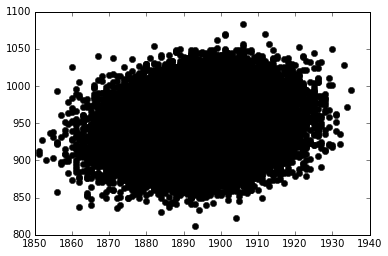

In [32]:
x = g.count_alleles(max_allele=2)[:, 0]
y = gm.count_alleles(max_allele=2)[:, 0]
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x, y, 'ko')

In [33]:
sh.sudo.drop_cache()
%timeit x = g.count_alleles(max_allele=2)
%timeit x = gc.count_alleles(max_allele=2)
%timeit x = gcp.count_alleles(max_allele=2)
%timeit x = gm.count_alleles(max_allele=2)
%timeit x = gcm.count_alleles(max_allele=2)
sh.sudo.drop_cache()
%memit x = g.count_alleles(max_allele=2)
%memit x = gc.count_alleles(max_allele=2)
%memit x = gcp.count_alleles(max_allele=2)
%memit x = gm.count_alleles(max_allele=2)
%memit x = gcm.count_alleles(max_allele=2)

10 loops, best of 3: 186 ms per loop
1 loops, best of 3: 294 ms per loop
1 loops, best of 3: 300 ms per loop
1 loops, best of 3: 265 ms per loop
1 loops, best of 3: 563 ms per loop
peak memory: 898.44 MiB, increment: 0.00 MiB
peak memory: 898.49 MiB, increment: 0.05 MiB
peak memory: 898.49 MiB, increment: 0.00 MiB
peak memory: 898.49 MiB, increment: 0.00 MiB
peak memory: 898.49 MiB, increment: 0.00 MiB


In [34]:
%timeit x = h.count_alleles(max_allele=2)
%timeit x = hc.count_alleles(max_allele=2)
%memit x = h.count_alleles(max_allele=2)
%memit x = hc.count_alleles(max_allele=2)

10 loops, best of 3: 185 ms per loop
1 loops, best of 3: 334 ms per loop
peak memory: 898.49 MiB, increment: 0.00 MiB
peak memory: 898.49 MiB, increment: 0.00 MiB


In [35]:
gsub = np.random.choice(list(range(g.shape[1])), size=(g.shape[1]//2), replace=False)
len(gsub)

500

In [36]:
np.array_equal(g.count_alleles(max_allele=2, subpop=gsub), 
               g.take(gsub, axis=1).count_alleles(max_allele=2))

True

In [37]:
%timeit x = g.count_alleles(max_allele=2, subpop=gsub)
%timeit x = g.take(gsub, axis=1).count_alleles(max_allele=2)
%timeit x = gc.count_alleles(max_allele=2, subpop=gsub)
%timeit x = gc.take(gsub, axis=1).count_alleles(max_allele=2)
%memit x = g.count_alleles(max_allele=2, subpop=gsub)
%memit x = g.take(gsub, axis=1).count_alleles(max_allele=2)
%memit x = gc.count_alleles(max_allele=2, subpop=gsub)
%memit x = gc.take(gsub, axis=1).count_alleles(max_allele=2)

10 loops, best of 3: 121 ms per loop
10 loops, best of 3: 173 ms per loop
1 loops, best of 3: 223 ms per loop
1 loops, best of 3: 365 ms per loop
peak memory: 898.82 MiB, increment: 0.00 MiB
peak memory: 946.51 MiB, increment: 47.69 MiB
peak memory: 899.28 MiB, increment: 0.46 MiB
peak memory: 899.28 MiB, increment: 0.00 MiB


In [38]:
sh.sudo.drop_cache()
%timeit x = g.count_alleles(max_allele=2, subpop=gsub)
%timeit x = gc.count_alleles(max_allele=2, subpop=gsub)
%timeit x = gcp.count_alleles(max_allele=2, subpop=gsub)
%timeit x = gm.count_alleles(max_allele=2, subpop=gsub)
%timeit x = gcm.count_alleles(max_allele=2, subpop=gsub)
sh.sudo.drop_cache()
%memit x = g.count_alleles(max_allele=2, subpop=gsub)
%memit x = gc.count_alleles(max_allele=2, subpop=gsub)
%memit x = gcp.count_alleles(max_allele=2, subpop=gsub)
%memit x = gm.count_alleles(max_allele=2, subpop=gsub)
%memit x = gcm.count_alleles(max_allele=2, subpop=gsub)

10 loops, best of 3: 118 ms per loop
1 loops, best of 3: 217 ms per loop
1 loops, best of 3: 218 ms per loop
1 loops, best of 3: 199 ms per loop
1 loops, best of 3: 610 ms per loop
peak memory: 899.29 MiB, increment: 0.00 MiB
peak memory: 899.29 MiB, increment: 0.00 MiB
peak memory: 899.29 MiB, increment: 0.00 MiB
peak memory: 899.29 MiB, increment: 0.00 MiB
peak memory: 899.29 MiB, increment: 0.00 MiB


In [39]:
hsub = [ploidy*i + n for i in gsub for n in range(ploidy)]
len(hsub)

1000

In [40]:
np.array_equal(h.count_alleles(max_allele=2, subpop=hsub), 
               h.take(hsub, axis=1).count_alleles(max_allele=2))

True

In [41]:
%timeit x = h.count_alleles(max_allele=2, subpop=hsub)
%timeit x = h.take(hsub, axis=1).count_alleles(max_allele=2)
%timeit x = hc.count_alleles(max_allele=2, subpop=hsub)
%timeit x = hc.take(hsub, axis=1).count_alleles(max_allele=2)
%memit x = h.count_alleles(max_allele=2, subpop=hsub)
%memit x = h.take(hsub, axis=1).count_alleles(max_allele=2)
%memit x = hc.count_alleles(max_allele=2, subpop=hsub)
%memit x = hc.take(hsub, axis=1).count_alleles(max_allele=2)

10 loops, best of 3: 111 ms per loop
10 loops, best of 3: 183 ms per loop
1 loops, best of 3: 218 ms per loop
1 loops, best of 3: 361 ms per loop
peak memory: 899.44 MiB, increment: 0.00 MiB
peak memory: 947.13 MiB, increment: 47.69 MiB
peak memory: 899.62 MiB, increment: 0.18 MiB
peak memory: 899.62 MiB, increment: 0.00 MiB


In [42]:
gsub1 = np.random.choice(list(range(g.shape[1])), size=(g.shape[1]//4), replace=False)
gsub2 = np.random.choice(list(range(g.shape[1])), size=(g.shape[1]//4), replace=False)
subpops = {'sub1': gsub1, 'sub2': gsub2}

In [43]:
%timeit gc.count_alleles_subpops(max_allele=2, subpops=subpops)
%timeit {name: gc.count_alleles(max_allele=2, subpop=subpop) for name, subpop in subpops.items()}
%memit gc.count_alleles_subpops(max_allele=2, subpops=subpops)
%memit {name: gc.count_alleles(max_allele=2, subpop=subpop) for name, subpop in subpops.items()}

1 loops, best of 3: 212 ms per loop
1 loops, best of 3: 354 ms per loop
peak memory: 899.71 MiB, increment: 0.00 MiB
peak memory: 899.71 MiB, increment: 0.00 MiB


In [44]:
x1 = gc.count_alleles_subpops(max_allele=2, subpops=subpops)
x1

sub1,sub2
[470 30 0],[468 32 0]
[471 29 0],[467 33 0]
[466 34 0],[482 18 0]
[476 24 0],[466 34 0]
[480 20 0],[476 24 0]


In [45]:
x1['sub1']

AlleleCountsCArray((50000, 3), int32)
  nbytes: 585.94 KB; cbytes: 340.64 KB; ratio: 1.72
  cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
[[470  30   0]
 [471  29   0]
 [466  34   0]
 ..., 
 [471  29   0]
 [480  20   0]
 [468  32   0]]

In [46]:
x1['sub2']

AlleleCountsCArray((50000, 3), int32)
  nbytes: 585.94 KB; cbytes: 340.79 KB; ratio: 1.72
  cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
[[468  32   0]
 [467  33   0]
 [482  18   0]
 ..., 
 [464  36   0]
 [464  36   0]
 [461  39   0]]

In [47]:
x2 = {name: gc.count_alleles(max_allele=2, subpop=subpop) for name, subpop in subpops.items()}
x2

{'sub1': AlleleCountsCArray((50000, 3), int32)
   nbytes: 585.94 KB; cbytes: 340.64 KB; ratio: 1.72
   cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
 [[470  30   0]
  [471  29   0]
  [466  34   0]
  ..., 
  [471  29   0]
  [480  20   0]
  [468  32   0]], 'sub2': AlleleCountsCArray((50000, 3), int32)
   nbytes: 585.94 KB; cbytes: 340.79 KB; ratio: 1.72
   cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
 [[468  32   0]
  [467  33   0]
  [482  18   0]
  ..., 
  [464  36   0]
  [464  36   0]
  [461  39   0]]}

In [48]:
np.array_equal(x1['sub2'], x2['sub2'])

True

## Subset operations

In [49]:
variants = np.random.randint(0, 2, size=n_variants).astype(bool)
np.count_nonzero(variants)

24896

In [50]:
samples = np.random.randint(0, 2, size=n_samples).astype(bool)
np.count_nonzero(samples)

498

In [51]:
gc.compress(variants, axis=0)

GenotypeCArray((24896, 1000, 2), int8)
  nbytes: 47.49 MB; cbytes: 8.23 MB; ratio: 5.77
  cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
[[[0 0]
  [0 0]
  [0 0]
  ..., 
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 1]
  [0 0]
  ..., 
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  ..., 
  [0 0]
  [0 0]
  [0 0]]

 ..., 
 [[0 0]
  [0 0]
  [0 0]
  ..., 
  [0 1]
  [0 0]
  [0 0]]

 [[0 0]
  [0 1]
  [0 0]
  ..., 
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 1]
  ..., 
  [0 0]
  [0 0]
  [0 0]]]

In [52]:
%timeit x = g.compress(variants, axis=0)
%timeit x = gc.compress(variants, axis=0)
%memit x = g.compress(variants, axis=0)
%memit x = gc.compress(variants, axis=0)

10 loops, best of 3: 38.5 ms per loop
1 loops, best of 3: 165 ms per loop
peak memory: 997.04 MiB, increment: 86.95 MiB
peak memory: 957.78 MiB, increment: 0.20 MiB


In [53]:
indices = np.nonzero(variants)[0]
%timeit x = g.take(indices, axis=0)
%timeit x = gc.take(indices, axis=0)
%memit x = g.take(indices, axis=0)
%memit x = gc.take(indices, axis=0)

10 loops, best of 3: 39.6 ms per loop
10 loops, best of 3: 168 ms per loop
peak memory: 1022.62 MiB, increment: 94.59 MiB
peak memory: 928.20 MiB, increment: -47.32 MiB


In [54]:
%timeit x = g.compress(samples, axis=1)
%timeit x = gc.compress(samples, axis=1)
%memit x = g.compress(samples, axis=1)
%memit x = gc.compress(samples, axis=1)

10 loops, best of 3: 61.2 ms per loop
1 loops, best of 3: 195 ms per loop
peak memory: 1017.19 MiB, increment: 89.00 MiB
peak memory: 975.69 MiB, increment: 0.00 MiB


In [55]:
indices = np.nonzero(samples)[0]
%timeit x = g.take(indices, axis=1)
%timeit x = gc.take(indices, axis=1)
%memit x = g.take(indices, axis=1)
%memit x = gc.take(indices, axis=1)

10 loops, best of 3: 61.3 ms per loop
1 loops, best of 3: 207 ms per loop
peak memory: 1022.81 MiB, increment: 94.61 MiB
peak memory: 975.69 MiB, increment: 0.00 MiB


In [56]:
%timeit x = g.subset(variants, samples)
%timeit x = gc.subset(variants, samples)
%memit x = g.subset(variants, samples)
%memit x = gc.subset(variants, samples)

1 loops, best of 3: 214 ms per loop
1 loops, best of 3: 343 ms per loop
peak memory: 932.95 MiB, increment: 0.00 MiB
peak memory: 932.98 MiB, increment: 0.04 MiB


In [57]:
gc.subset(variants, samples)

GenotypeCArray((24896, 498, 2), int8)
  nbytes: 23.65 MB; cbytes: 4.32 MB; ratio: 5.47
  cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
[[[1 1]
  [0 0]
  [0 0]
  ..., 
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 1]
  [0 0]
  ..., 
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  ..., 
  [0 0]
  [0 0]
  [0 0]]

 ..., 
 [[0 0]
  [0 1]
  [0 0]
  ..., 
  [0 0]
  [0 1]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  ..., 
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  ..., 
  [0 0]
  [0 0]
  [0 0]]]

In [59]:
gms = gm.subset(variants, samples)
gms.shape, gms.mask.shape

((24896, 498, 2), (24896, 498))

In [60]:
gcms = gcm.subset(variants, samples)
gcms.shape, gcms.mask.shape

((24896, 498, 2), (24896, 498))

## Sandbox